In [38]:
import pandas as pd 
import csv
import re
import random
import pickle
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from wordcloud import WordCloud

In [4]:
from nltk.stem import WordNetLemmatizer

In [5]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [6]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [7]:
embedding_dim=100
max_langht=16
trunc_type="post"
padding_type="post"
training_size=1600000
test_portion=0.1
oov_tak="<oov>"

In [8]:
corpus= []

In [9]:
dataset_colums = ["sentiment","ids","date","flag","user","text"]
dataset_encodding = "ISO-8859-1"
dataset=pd.read_csv("SentimentDatasets.csv", encoding=dataset_encodding ,names=dataset_colums)

In [10]:
dataset.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [11]:
dataset.describe()

,sentiment,ids
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [13]:
dataset.columns


Index(['sentiment', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [14]:
new_dataset=dataset[['sentiment','text']]

In [15]:
new_dataset.columns

Index(['sentiment', 'text'], dtype='object')

In [16]:
new_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   text       1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [17]:
new_dataset.sentiment.value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

In [18]:
new_dataset['sentiment']=new_dataset['sentiment'].replace(4,1)

C:\Users\Shadin\AppData\Local\Temp/ipykernel_8600/456226980.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataset['sentiment']=new_dataset['sentiment'].replace(4,1)


In [19]:
new_dataset['sentiment'].value_counts()

0    800000
1    800000
Name: sentiment, dtype: int64

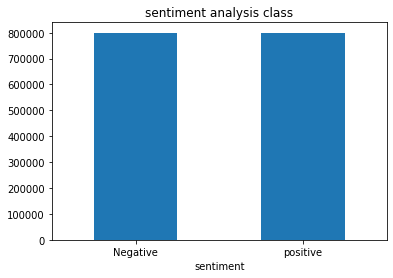

In [20]:
ax=new_dataset.groupby('sentiment').count().plot(kind='bar',
                                                title='sentiment analysis class',
                                                legend=False)
ax.set_xticklabels(["Negative","positive"],rotation=0)

plt.show()

In [21]:
text, sentiment = list(new_dataset['text']), list(new_dataset['sentiment'])

In [22]:
text[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [23]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
'@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
'<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [24]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [25]:
def data_preprocess(textdata):
    processedText = []
    word_Lem = WordNetLemmatizer()
    
    url_pattern = r"((http://)[^ ]*|(https://)^ ]*( www\.)[^ ]*)"
    user_pattern = '@[^\s]+'
    alpha_pattern = "[^a-zA-Z0-9]"
    sequence_pattern = r"(.)\1\1+"
    sequence_pattern_replace = "\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        tweet = re.sub(url_pattern, " URL", tweet)
        
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
            
        tweet = re.sub(user_pattern, "USER", tweet)
        tweet = re.sub(alpha_pattern, " ", tweet)
        tweet = re.sub(sequence_pattern, sequence_pattern_replace, tweet)
        
        
        tweetwords = ""
        for word in tweet.split():
            if len(word) > 1:
                word  = word_Lem.lemmatize(word)
                tweetwords += (word+ " ")
                
        processedText.append(tweetwords)
        
    return processedText

In [26]:
import time
t = time.time()
processtext = data_preprocess(text)
print("Time taken for process: ", round(time.time() - t), "Seconds")

Time taken for process:  152 Seconds


In [27]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shadin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
data_neg = processtext[:800000]
data_pos = processtext[800000:]

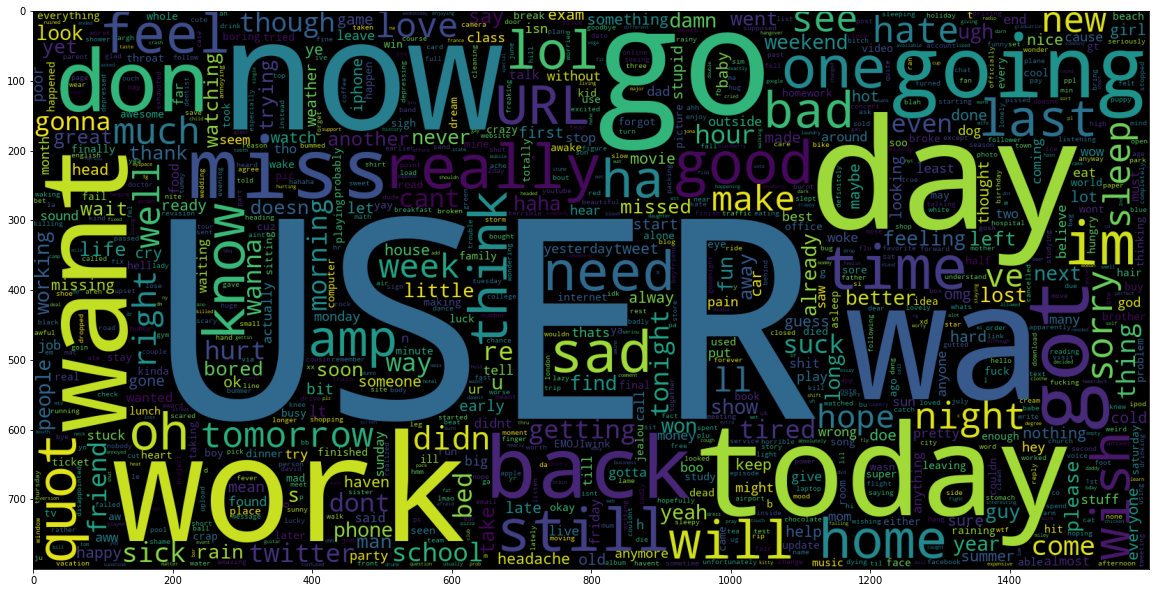

In [29]:
plt.figure(figsize = (20, 18))
wc = WordCloud(max_words= 1000, width = 1600, height = 800,
              collocations = False).generate(" ".join(data_neg))
plt.imshow(wc)
plt.show()

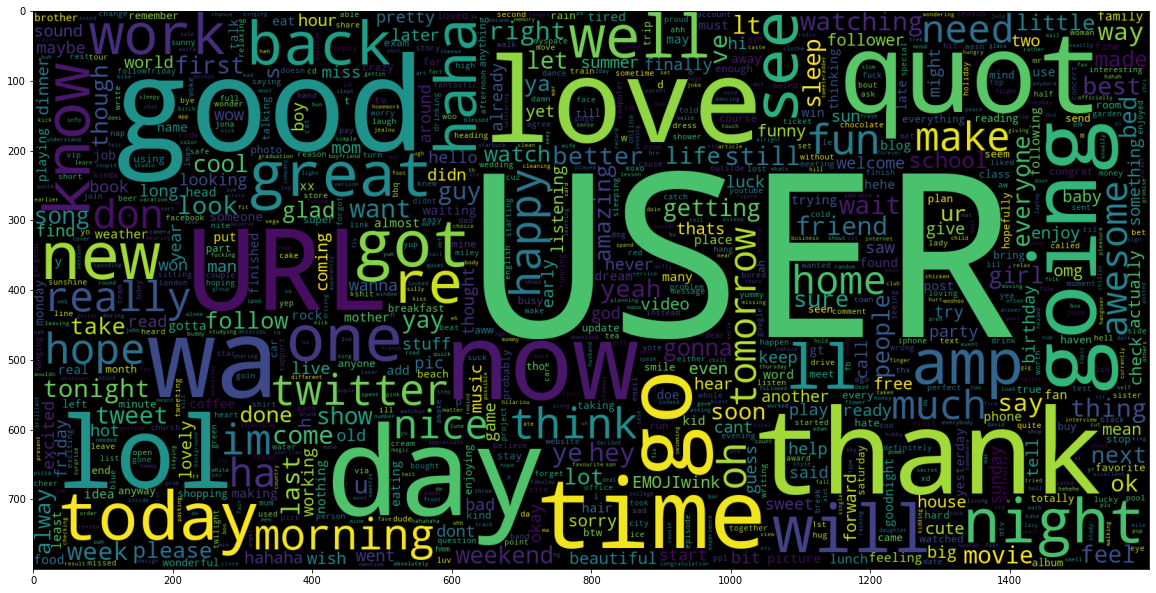

In [30]:
plt.figure(figsize = (20, 18))
wc = WordCloud(max_words= 1000, width = 1600, height = 800,
              collocations = False).generate(" ".join(data_pos))
plt.imshow(wc)
plt.show()

In [31]:
X_train, X_test, y_train, y_test  = train_test_split(processtext,
                                                    sentiment, 
                                                    test_size = 0.2, random_state=0)

In [32]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
vectorizer.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [33]:
X_train = vectorizer.transform(X_train)

In [34]:
vectorizer


TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [35]:
X_test = vectorizer.transform(X_test)

In [42]:
def Model_Evaluate(model):
    y_pred = model.predict(X_test)
    print("Classification Report: ", classification_report(y_test, y_pred))
    
    Confusion_matrix = confusion_matrix(y_test, y_pred)
    
    categories = ["Negative", "Positive"]
    group_names_check = ["True Negative", "False Positive", "False Negative", "True Positive"]
    
    group_names_percentage = ['{0:.2%}'.format(value) for value in Confusion_matrix.flatten() / np.sum(Confusion_matrix)]
    
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names_check, group_names_percentage)]
    labels = np.asarray(labels).reshape(2, 2)
    
    
    sns.heatmap(Confusion_matrix, annot = labels, 
               cmap = "Reds", fmt = "",
               xticklabels=categories, yticklabels=categories)

    plt.xlabel("Predicted Values", fontdict= {"size":14}, labelpad= 10)
    plt.ylabel("Actual Values", fontdict= {"size":14}, labelpad= 10)
    plt.title("Confusion Metrix", fontdict= {"size":14}, pad= 10)
    plt.show()

Classification Report:                precision    recall  f1-score   support

           0       0.80      0.79      0.80    159815
           1       0.79      0.81      0.80    160185

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



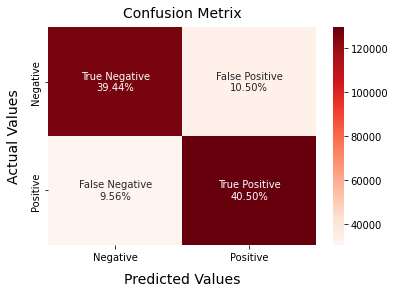

In [43]:
BN = BernoulliNB(alpha=2)
BN.fit(X_train, y_train)
Model_Evaluate(BN)

Classification Report:                precision    recall  f1-score   support

           0       0.82      0.81      0.81    159815
           1       0.81      0.82      0.82    160185

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



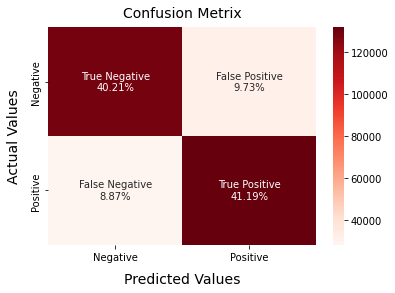

In [44]:
SVC_MODEL = LinearSVC()
SVC_MODEL.fit(X_train, y_train)
Model_Evaluate(SVC_MODEL)

Classification Report:                precision    recall  f1-score   support

           0       0.83      0.81      0.82    159815
           1       0.82      0.83      0.83    160185

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



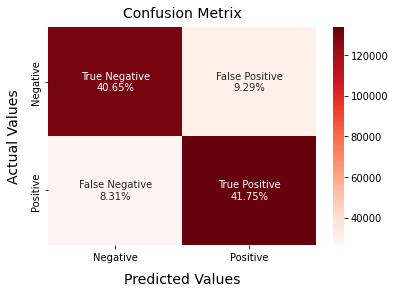

In [45]:
LG_MODEL = LogisticRegression(C= 2, max_iter = 1000, n_jobs = -1)
LG_MODEL.fit(X_train, y_train)
Model_Evaluate(LG_MODEL)

In [46]:
file =  open("vectorizer-ngram-(1, 2).pickle", 'wb')
pickle.dump(vectorizer, file)
file.close()

file =  open("LogisticRegression.pickle", 'wb')
pickle.dump(LG_MODEL, file)
file.close()

file =  open("BNB.pickle", 'wb')
pickle.dump(BN, file)
file.close()

In [47]:
def load_models():
    file = open("vectorizer-ngram-(1, 2).pickle", 'rb')
    vectorizer = pickle.load(file)
    file.close()
    
    file = open("LogisticRegression.pickle", 'rb')
    LR = pickle.load(file)
    file.close()
    
    return vectorizer, LR

In [48]:
y_pred_BN = BN.predict(X_test)
BernoulliNB_model = accuracy_score(y_test, y_pred_BN)

y_pred_SVC = SVC_MODEL.predict(X_test)
SVC_model = accuracy_score(y_test, y_pred_SVC)

y_pred_LR = LG_MODEL.predict(X_test)
LR_model = accuracy_score(y_test, y_pred_LR)


print("BN accuracy", BernoulliNB_model)
print("SVC accuracy", SVC_model)
print("LR accuracy", LR_model)

BN accuracy 0.799428125
SVC accuracy 0.813975
LR accuracy 0.82399375


In [49]:
def Predict(vectorizer, model, text):
    text_data = vectorizer.transform(data_preprocess(text))
    sentiment_label = model.predict(text_data)
    
    output_data = []
    for text, pred in zip(text, sentiment):
        output_data.append((text, pred))
        
        
    df = pd.DataFrame(output_data, columns = ["text", "Sentiment"])
    df = df.replace([0, 1], ["Negative", "Positive"])
    
    return df

In [50]:
test_data = ["Machine Learning is a good learning field",
            "Deep Learning is a not good learning field",
            "AI is a good learning field but Not very much good"]

In [51]:
Predict(vectorizer, LG_MODEL, test_data)

,text,Sentiment
0,Machine Learning is a good learning field,Negative
1,Deep Learning is a not good learning field,Negative
2,AI is a good learning field but Not very much ...,Negative
